# QUBO Solution of the hydraulics equations
In this notebook we illustrate how to solve the hydraulics equations using a pure QUBO approach. 

## Hydraulics equations
In their most basic form the hydraulics equations read:

$$
    \sum_j q_{ij} - D_i = 0 \newline
    h_{L_{ij}} \equiv h_i - h_j = A |q_{ij}| q_{ij}^{B-1}
$$

where $h_i$ is the head pressure at node $i$, $A$ the resistance coefficient and $B$ the flow exponent. 
Several approximations have been developed for define $A$ and $B$. The popular Hazen-Williams (HW) approximation uses $B=1.852$. The HW is therefore not suited for a QUBO formulation that requires integer exponents in the formulation of the objective function. In contrast, the Chezy-Manning (CM) and Darcy-Weisbach (DW) approximation use $B=2$. We have implemented DW and CM hydraulics models that can found under `wntr_quantum/sim/models/`.


The presence of absolute values in the hydraulics equation makes it difficult to use the approach we just described. We therefore express the flow values as:

$$
    q_{ij} = s_{ij} |q_{ij}| \equiv s_{ij} y_{ij}
$$

This leads to the equations:

$$
    \sum_j s_{ij} y_{ij} - D_i = 0 \newline
    h_{L_{ij}} \equiv h_i - h_j = A s_{ij} y_{ij}^{B}
$$

In these forms the hydraulics equation can be seen as a system of non-linear equations with integeer power of the unknown: 

$$
F(s_{ij}, y_{ij}, h_i)=0
$$

 ## Solving non linear systems with a QUBO approach
 
 We closely following an approach developed in this [http://dx.doi.org/10.1038/s41598-019-46729-0](paper) to solve the non linear system. 
 
 
The method proposes to solve a non-linear system, given by $F(X) = 0$ by first decomposing the system of equations as a sum of tensor products:

$$
    F_i = P_i^{(0)} + \sum_j P_{ij}^{(1)}x_j + \sum_{jk} P_{ijk}^{(2)}x_j x_k + \sum_{jkl} P_{ijkl}^{(3)}x_j x_k x_l = 0 
$$

To find the solution of the system one can then minimise the residual sum of squares

$$
\chi^2 = \left[ P^{(0)} + P^{(1)} X + P^{(2)} X^2 + P^{(3)} X^3 + ... \right]^2
$$

By encoding all the variables as binary expansions we obtain a high order boolean polynomial. To solve this problem with a QUBO formalism, the high order terms have to be quadratized by introducing additional binary variables and appropriate terms in the loss function. The resulting QUBO problem can then be solved using either classical simulated annealing or quantum annealers alike.

## Example

We demonstrate in the following how to us our software to solve the hydraulics equations with a QUBO approach.

### Reference Solution

We first define the problem and solve it classically to obtain a benchmark solution

In [1]:
import wntr

inp_file = "./networks/Net0.inp"
wn = wntr.network.WaterNetworkModel(inp_file)

We solve the problem using the default `EPANET` simulator 

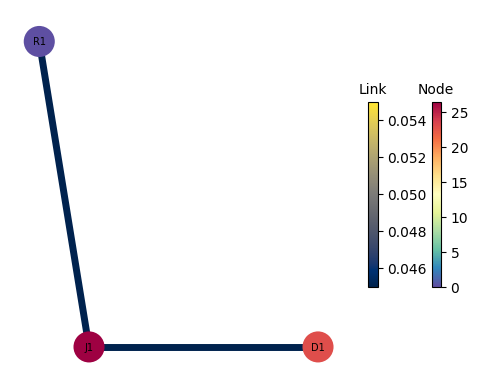

<Axes: >

In [2]:
import matplotlib.pyplot as plt

# solve the problem
sim = wntr.sim.EpanetSimulator(wn)
reference_results = sim.run_sim()

# Plot results on the network
pressure_at_5hr = reference_results.node["pressure"].loc[0, :]
flow_at_5hr = reference_results.link["flowrate"].loc[0, :]
wntr.graphics.plot_network(
    wn,
    link_attribute=flow_at_5hr,
    node_attribute=pressure_at_5hr,
    node_size=500,
    link_width=5,
    node_labels=True,
    link_cmap=plt.cm.cividis,
)

We extract the values of the pressure and flows for future use

In [3]:
import numpy as np

ref_pressure = reference_results.node["pressure"].values[0][:2]
ref_rate = reference_results.link["flowrate"].values[0]
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 0.05 ,  0.05 , 26.477, 22.954], dtype=float32)

### QUBO Polynomial Solver

We now show how to solve the problem using the QUBO polynomial solver included in `wntr_quantum`. We start with redefining the water network.

In [4]:
wn = wntr.network.WaterNetworkModel(inp_file)

The unknown of the problem can take continuous values and therefore must be encoded using several qubits before being used in a QUBO formulation. We use here the encoding implemented in our library `qubops`. We use these encoding schemes to instantiate the polynomial solver. 

In [5]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.encodings import PositiveQbitEncoding

nqbit = 7
step = 4.0 / (2**nqbit - 1)
flow_encoding = PositiveQbitEncoding(
    nqbit=nqbit, step=step, offset=+0, var_base_name="x"
)

nqbit = 7
step = 200 / (2**nqbit - 1)
head_encoding = PositiveQbitEncoding(
    nqbit=nqbit, step=step, offset=+0.0, var_base_name="x"
)

net = QuboPolynomialSolver(wn, flow_encoding=flow_encoding, head_encoding=head_encoding)
net.verify_encoding()

Head Encoding : 0.000000 => 200.000000 (res: 1.574803)
Flow Encoding : -4.000000 => -0.000000 | 0.000000 => 4.000000 (res: 0.031496)


We then solve the QUBO equations classically. This gives us: a reference solution, the best possible encoded solution, the total encoded solution including all slack variables and the QUBO energy of the solution.

In [6]:
ref_sol, encoded_ref_sol, bin_rep_sol, eref, cvgd = net.classical_solution()

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


### Initial sample for the QUBO optimization 

Before minimizing the energy of the QUBO problem we need to define the initial configuration of the binary variables in the QUBO problem. We have implemented two different ways to obtain an initial sample that respects all the conditions imposed by the quadratization constraings of the polynomial qubo solver. 

We can for example create a completely random sample that simply ensure that quadratization constraints are respected

In [7]:
from wntr_quantum.sampler.simulated_annealing import generate_random_valid_sample

x = generate_random_valid_sample(net)
x0 = list(x.values())

Alternatively we can modify the solution calculated in `.classical_solution()`. This can be useful when one wants to reuse exact values of the flows or pressure

In [8]:
from wntr_quantum.sampler.simulated_annealing import modify_solution_sample

x = modify_solution_sample(net, bin_rep_sol, modify=["flows", "heads"])
x0 = list(x.values())

### Temperature scheduling for the Simulated Annealing optimization

One important parameters of the simulated Annealing process is the the so-called temperature schedule. This schdule defines the acceptance probability of the new samples that increase the QUBO energy. While high temperature that leads to accepting samples that increase energy is usefull to escape local minima the temperature must be decreased in order to converge towards a minima. 

The temperature schedule usually starts with high temperature values that allows to explore the energy landscape but progressively decrease the tempearture in order for the optimization to converge. 

In [9]:
num_temp = 2000
Tinit = 1e1
Tfinal = 1e-1
Tschedule = np.linspace(Tinit, Tfinal, num_temp)
Tschedule = np.append(Tschedule, Tfinal * np.ones(1000))
Tschedule = np.append(Tschedule, np.zeros(1000))

We can then use the `solve()` method of the qubo polynomial solver to obtain a solution of the problem

In [10]:
net.step_func.optimize_values = np.arange(2, 6)
_, _, sol, res = net.solve(
    init_sample=x0, Tschedule=Tschedule, save_traj=True, verbose=False
)

100%|██████████| 4000/4000 [00:05<00:00, 708.12it/s]


We can plot the evoluion of the QUBO energy along the optimization path

Text(0.5, 0, 'Iterations')

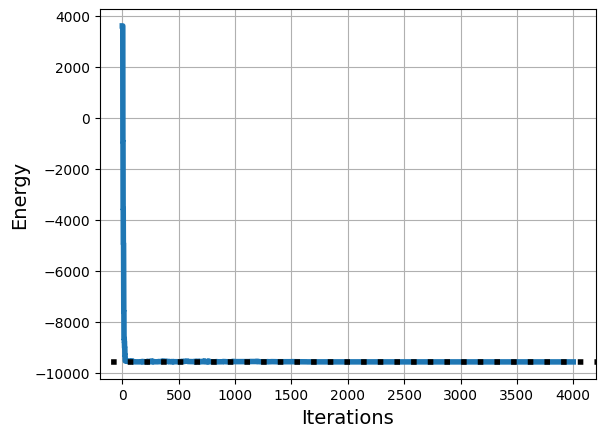

In [11]:
import matplotlib.pyplot as plt

plt.plot(res.energies[:], lw=4, label="QUBO Energy")
plt.axline((0, eref[0]), slope=0, color="black", lw=4, linestyle=(4, (1, 2)))
plt.grid(which="both")
plt.ylabel("Energy", fontsize=14)
plt.xlabel("Iterations", fontsize=14)

We can also plot the reference solution and the QUBO solution for visual inspection

Text(0.5, 1.0, 'Pressure')

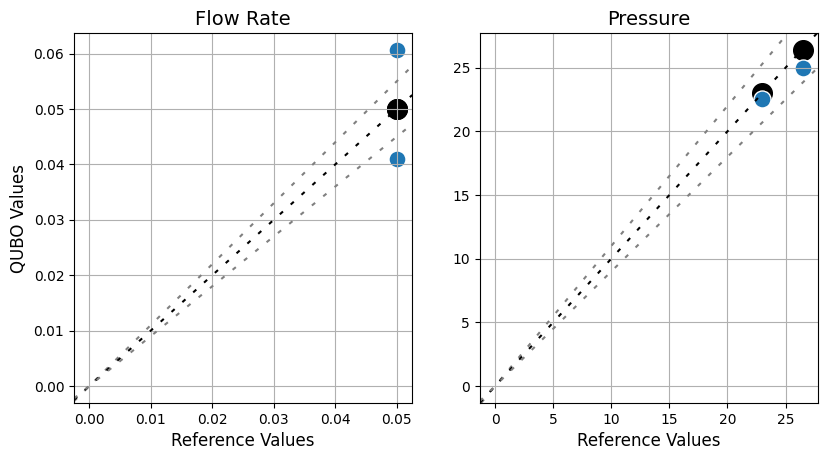

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig.add_subplot(121)

ax1.axline((0, 0.0), slope=1.10, color="grey", linestyle=(0, (2, 5)))
ax1.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
ax1.axline((0, 0.0), slope=0.90, color="grey", linestyle=(0, (2, 5)))
ax1.grid()

ax1.scatter(
    ref_values[:2], encoded_ref_sol[:2], c="black", s=200, label="Best solution"
)
ax1.scatter(
    ref_values[:2], sol[:2], s=150, lw=1, edgecolors="w", label="Sampled solution"
)


ax1.set_xlabel("Reference Values", fontsize=12)
ax1.set_ylabel("QUBO Values", fontsize=12)
ax1.set_title("Flow Rate", fontsize=14)

ax2 = fig.add_subplot(122)

ax2.axline((0, 0.0), slope=1.10, color="grey", linestyle=(0, (2, 5)))
ax2.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
ax2.axline((0, 0.0), slope=0.90, color="grey", linestyle=(0, (2, 5)))


ax2.scatter(
    ref_values[2:], encoded_ref_sol[2:], c="black", s=200, label="Best solution"
)
ax2.scatter(
    ref_values[2:], sol[2:], s=150, lw=1, edgecolors="w", label="Sampled solution"
)
ax2.grid()


ax2.set_xlabel("Reference Values", fontsize=12)
ax2.set_title("Pressure", fontsize=14)